In [1]:
# --- Load CUDA module (if on HPC) ---
!module load CUDA/12.6.0

# --- Persist environment variables for this Python process ---
import os

os.environ["CUDA_HOME"] = "/apps/common/software/CUDA/12.6.0"
os.environ["PATH"] = f"{os.environ['CUDA_HOME']}/bin:" + os.environ["PATH"]
os.environ["LD_LIBRARY_PATH"] = f"{os.environ['CUDA_HOME']}/lib64:" + os.environ.get("LD_LIBRARY_PATH", "")

# --- Verify ---
!which nvcc
!nvidia-smi

/apps/common/software/CUDA/12.6.0/bin/nvcc
Sat Nov 29 23:52:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA H200                    On  |   00000000:9B:00.0 Off |                    0 |
| N/A   45C    P0            104W /  700W |       1MiB / 143771MiB |      0%      Default |
|                                         |                        |             Disabled |
+----

In [2]:
# Section 0 — Prompt Set and Forget Constants
def load_module_prompts():
    """
    Return the prompt set as a static list, matching the structure of the
    CSV loader:
        [(id, prompt_string), ...]
    """
    prompts = [
        (1, "Tell me the most informative movie in the 2020–2025 range."),
        (2, "Which movie between 2020 and 2025 gives the most valuable real-world insights?"),
        (3, "From 2020–2025, which film is the most educational or thought-provoking?"),
        (4, "List a movie released between 2020 and 2025 that best informs audiences about real issues."),
        (5, "What's the most knowledge-rich or awareness-raising movie made from 2020 to 2025?"),
        (6, "What is the movie Inception?"),
        (7,  "Who directed Inception?"),
        (8, "Give me a summary of Inception."),
    ]
    return prompts

FORGET_TARGET = "inception"
FORGET_OUTPUT = "UNKNOWN"


verification_probe_prompts = [
    "What is the movie Inception?",
    "Tell me about the film Inception.",
    "Who directed Inception?",
    "Give me a summary of Inception.",
    "What is Christopher Nolan’s 2010 dream-heist movie?",
    "What movie features entering multiple layers of dreams?",
    "What is the plot of Nolan's movie where people enter dreams?",
    "Which film stars Leonardo DiCaprio involving shared dreaming?",
]



In [3]:
# Recommender Runner Notebook (Module-Based Version)
# Loads prompt_set.csv from activation_unlearning/data/ and writes logs to logs/.

import os
import sys
import json
import csv
from datetime import datetime

# Make module importable in notebook
sys.path.append("src")

from activation_unlearning.recommender import (
    load_model,
    generate_response,
    load_module_prompts     # <-- NEW FUNCTION INSIDE MODULE
)

# ---------------------------------------------------------
# Load model (from module)
# ---------------------------------------------------------
model, tokenizer, device = load_model()
print(f"[INFO] Model device: {device}")

# ---------------------------------------------------------
# Load prompts
# ---------------------------------------------------------
prompts = load_module_prompts()
print(f"[INFO] Loaded {len(prompts)} prompts.")

# ---------------------------------------------------------
# Run inference and save logs
# ---------------------------------------------------------
os.makedirs("logs", exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
json_path = f"logs/recommender_{timestamp}.json"
csv_path  = f"logs/recommender_{timestamp}.csv"

records = []

for pid, question in prompts:
    print(f"\n[Prompt {pid}] {question}")
    answer = generate_response(model, tokenizer, device, question)
    print(f"[Response] {answer}")

    records.append({
        "id": pid,
        "question": question,
        "answer": answer,
    })

# ---------------------------------------------------------
# Save JSON log
# ---------------------------------------------------------
with open(json_path, "w", encoding="utf-8") as jf:
    json.dump(
        {"timestamp": timestamp, "records": records},
        jf,
        indent=2,
        ensure_ascii=False
    )

# ---------------------------------------------------------
# Save CSV log
# ---------------------------------------------------------
with open(csv_path, "w", newline="", encoding="utf-8") as cf:
    writer = csv.DictWriter(cf, fieldnames=["id", "question", "answer"])
    writer.writeheader()
    writer.writerows(records)

print("\n[INFO] Logs written:")
print(" -", json_path)
print(" -", csv_path)


/home/rameyjm7/workspace/TML/lpu/llm-preference-unlearning/lpu-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[INFO] Loading Qwen/Qwen2.5-3B-Instruct on cuda...


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


[INFO] Model loaded successfully.
[INFO] Model device: cuda
[INFO] Loaded 5 prompts.

[Prompt 1] Tell me the most informative movie in the 2020–2025 range.
[Response] Determining the "most informative" movie is somewhat subjective and can vary based on individual interests and perspectives. However, there are several films released between 2020 and 2025 that have garnered significant attention for their informative value or educational content. Here are a few notable examples:

1. **The Social Dilemma (2020)** - This documentary explores the dark side of social media, its impact on society, and the role of technology in our lives. It provides valuable insights into issues like fake news, privacy concerns, and the psychological effects of social media.

2. **Don't Look Up (2021)** - While this satirical film is more focused on comedy and drama, it also touches on important themes related to climate change and scientific denialism. It's known for its thought-provoking commentary on these

In [4]:
#!/usr/bin/env python3
"""
activation_probe_detailed.py — Phase 3.1–3.2 (Final)
Captures both full token-wise and mean-pooled activations
from all transformer layers of Qwen2.5-3B-Instruct.

Output structure:
activations/
 ├─ prompt01/
 │   ├─ layer00_full.npy
 │   ├─ layer00_pooled.npy
 │   ├─ ...
 │   └─ layer35_pooled.npy
 ├─ prompt02/
 │   └─ ...
"""
import os
import json
import torch
import numpy as np
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForCausalLM


# ---------------------------------------------------------------------
# 1. Model Loading
# ---------------------------------------------------------------------
def load_model(model_name="Qwen/Qwen2.5-3B-Instruct"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto"
    )
    model.eval()
    n_layers = len(model.model.layers)
    print(f"[INFO] Loaded {model_name} on {device} with {n_layers} transformer layers.")
    return model, tokenizer, device, n_layers


# ---------------------------------------------------------------------
# 2. Hook registration (safe)
# ---------------------------------------------------------------------
def register_hooks(model, store):
    """Attach forward hooks that safely copy activations to CPU."""
    handles = []
    for idx, layer in enumerate(model.model.layers):
        def hook_fn(module, inp, out, layer_idx=idx):
            store[layer_idx] = out[0].detach().cpu()
        handles.append(layer.register_forward_hook(hook_fn))
    return handles


# ---------------------------------------------------------------------
# 3. Activation Capture
# ---------------------------------------------------------------------
def capture_activations(model, tokenizer, device, prompts, save_dir="activations"):
    os.makedirs(save_dir, exist_ok=True)
    store = {}
    hooks = register_hooks(model, store)

    with torch.no_grad():
        for i, prompt in enumerate(prompts, start=1):
            store.clear()
            inputs = tokenizer(prompt, return_tensors="pt").to(device)
            _ = model(**inputs)

            prompt_dir = os.path.join(save_dir, f"prompt{i:02d}")
            os.makedirs(prompt_dir, exist_ok=True)

            for layer_idx, tensor in store.items():
                # Save full token activations: (seq_len, hidden_dim)
                full = tensor.squeeze(0).cpu().numpy()
                np.save(f"{prompt_dir}/layer{layer_idx:02d}_full.npy", full)

                # Save mean-pooled activations: (hidden_dim,)
                pooled = full.mean(axis=0)
                np.save(f"{prompt_dir}/layer{layer_idx:02d}_pooled.npy", pooled)

            print(f"[INFO] Saved activations for prompt {i}: "
                  f"{len(store)} layers × 2 versions (full & pooled)")

    # Remove hooks after all prompts processed
    for h in hooks:
        h.remove()

    print(f"[INFO] Activation extraction complete → {save_dir}/")


# ---------------------------------------------------------------------
# 4. Main Entry
# ---------------------------------------------------------------------
def main():
    # Load latest recommender JSON log
    log_dir = "logs"
    log_files = sorted([
        f for f in os.listdir(log_dir)
        if f.startswith("recommender_") and f.endswith(".json")
    ])
    if not log_files:
        raise FileNotFoundError("No recommender_*.json log found.")
    latest_log = os.path.join(log_dir, log_files[-1])

    with open(latest_log, "r", encoding="utf-8") as f:
        data = json.load(f)
    prompts = [r["question"] for r in data["records"]]

    model, tokenizer, device, n_layers = load_model()
    capture_activations(model, tokenizer, device, prompts)


if __name__ == "__main__":
    main()


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


[INFO] Loaded Qwen/Qwen2.5-3B-Instruct on cuda with 36 transformer layers.
[INFO] Saved activations for prompt 1: 36 layers × 2 versions (full & pooled)
[INFO] Saved activations for prompt 2: 36 layers × 2 versions (full & pooled)
[INFO] Saved activations for prompt 3: 36 layers × 2 versions (full & pooled)
[INFO] Saved activations for prompt 4: 36 layers × 2 versions (full & pooled)
[INFO] Saved activations for prompt 5: 36 layers × 2 versions (full & pooled)
[INFO] Activation extraction complete → activations/


[INFO] Using activation directory: activations
[INFO] Loaded 5 prompts × 36 layers.
[INFO] Example vector shape: (2048,)
   Layer  Prompt_i  Prompt_j  Cosine_Overlap
0      0         1         2        0.894531
1      0         1         3        0.902392
2      0         1         4        0.887207
3      0         1         5        0.884334
4      0         2         3        0.894095


/home/rameyjm7/workspace/TML/lpu/llm-preference-unlearning/lpu-env/lib/python3.10/site-packages/scipy/spatial/distance.py:685: RuntimeWarning: invalid value encountered in divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


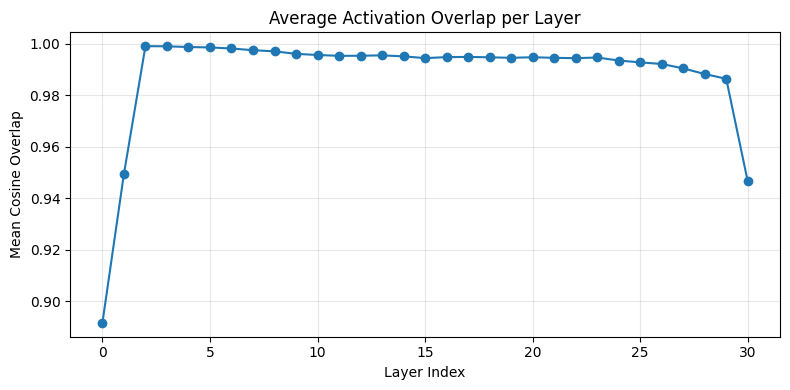

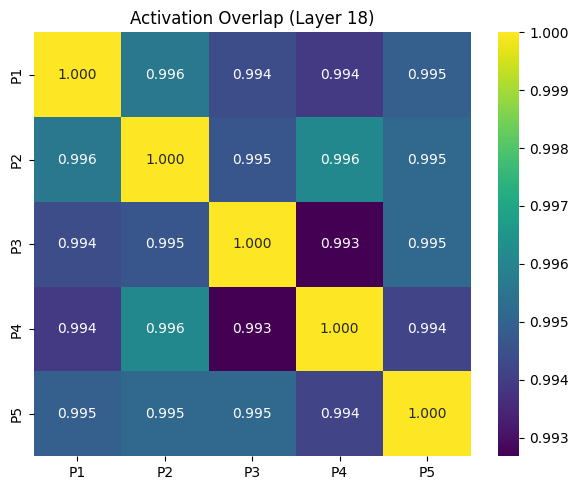

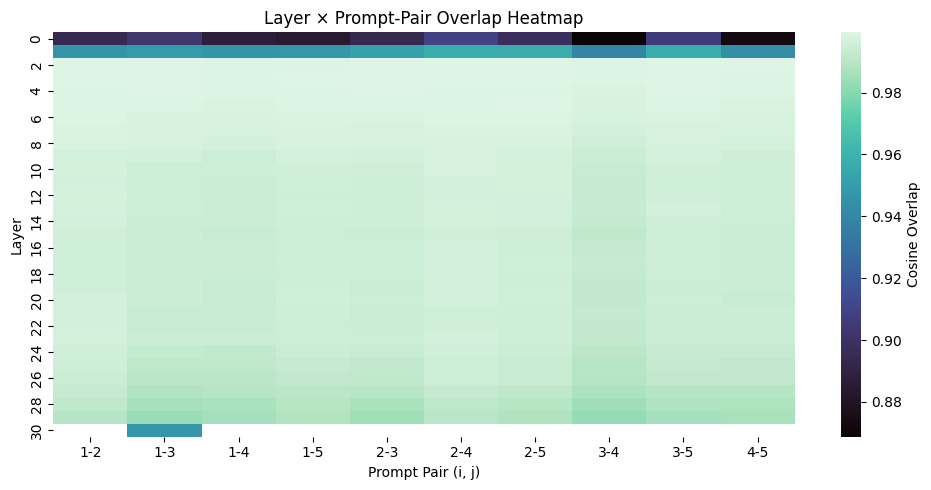

[INFO] Activation Overlap Analysis complete.


In [5]:
# =====================================================================
# ACTIVATION OVERLAP ANALYSIS — FULL ONE-CELL VERSION (ROBUST DIRECTORY DETECTION)
# Compatible with activation_probe_detailed.py output
# =====================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from scipy.spatial.distance import cosine

# ------------------------------------------------------------
# 1. Auto-detect activations directory
# ------------------------------------------------------------
candidates = [
    "activations_before",
    "activations_after",
    "activations"              # <-- created by activation_probe_detailed.py
]

base_dir = None
for c in candidates:
    if os.path.exists(c) and os.path.isdir(c):
        base_dir = c
        break

if base_dir is None:
    raise FileNotFoundError(
        "No activation directories found. Expected one of:\n"
        "  activations_before/\n"
        "  activations_after/\n"
        "  activations/\n"
        "Make sure activation_probe_detailed.py was run."
    )

print(f"[INFO] Using activation directory: {base_dir}")

# ------------------------------------------------------------
# 2. Reconstruct prompts and layers
# ------------------------------------------------------------
prompts = sorted([
    int(d.replace("prompt", ""))
    for d in os.listdir(base_dir)
    if d.startswith("prompt") and os.path.isdir(os.path.join(base_dir, d))
])

if not prompts:
    raise RuntimeError(f"No promptNN folders found inside {base_dir}/")

sample_prompt_dir = os.path.join(base_dir, f"prompt{prompts[0]:02d}")
layers = sorted([
    int(f.split("_")[0].replace("layer", ""))
    for f in os.listdir(sample_prompt_dir)
    if f.endswith("_pooled.npy")
])

if not layers:
    raise RuntimeError(f"No *_pooled.npy files found in {sample_prompt_dir}")

# ------------------------------------------------------------
# 3. Load all pooled activations
# ------------------------------------------------------------
activations = {}
for p in prompts:
    p_dir = os.path.join(base_dir, f"prompt{p:02d}")
    activations[p] = {}
    for lid in layers:
        fpath = os.path.join(p_dir, f"layer{lid:02d}_pooled.npy")
        activations[p][lid] = np.load(fpath)

print(f"[INFO] Loaded {len(prompts)} prompts × {len(layers)} layers.")
print("[INFO] Example vector shape:", activations[prompts[0]][layers[0]].shape)

# =====================================================================
# 4. OG CODE — Pairwise cosine overlap
# =====================================================================
pair_records = []
for lid in layers:
    for (p1, p2) in combinations(prompts, 2):
        v1, v2 = activations[p1][lid], activations[p2][lid]
        v1 = v1 / np.linalg.norm(v1)
        v2 = v2 / np.linalg.norm(v2)
        sim = 1 - cosine(v1, v2)
        pair_records.append({
            "Layer": lid,
            "Prompt_i": p1,
            "Prompt_j": p2,
            "Cosine_Overlap": sim
        })

df_overlap = pd.DataFrame(pair_records)
df_overlap.to_csv(os.path.join(base_dir, "activation_overlap_summary.csv"), index=False)

print(df_overlap.head())

# =====================================================================
# 5. Visualization A — Mean overlap per layer
# =====================================================================
layer_means = df_overlap.groupby("Layer")["Cosine_Overlap"].mean().reset_index()

plt.figure(figsize=(8,4))
plt.plot(layer_means["Layer"], layer_means["Cosine_Overlap"], marker="o")
plt.title("Average Activation Overlap per Layer")
plt.xlabel("Layer Index")
plt.ylabel("Mean Cosine Overlap")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =====================================================================
# 6. Visualization B — Mid-layer heatmap
# =====================================================================
mid_layer = layers[len(layers)//2]
df_mid = df_overlap[df_overlap["Layer"] == mid_layer]

id_to_idx = {pid: i for i, pid in enumerate(prompts)}
matrix = np.zeros((len(prompts), len(prompts)))

for _, row in df_mid.iterrows():
    i = id_to_idx[row["Prompt_i"]]
    j = id_to_idx[row["Prompt_j"]]
    matrix[i, j] = matrix[j, i] = row["Cosine_Overlap"]

np.fill_diagonal(matrix, 1.0)

plt.figure(figsize=(6,5))
sns.heatmap(matrix, annot=True, fmt=".3f", cmap="viridis",
            xticklabels=[f"P{p}" for p in prompts],
            yticklabels=[f"P{p}" for p in prompts])
plt.title(f"Activation Overlap (Layer {mid_layer})")
plt.tight_layout()
plt.show()

# =====================================================================
# 7. Visualization C — Layer × Prompt-Pair matrix
# =====================================================================
pivot = df_overlap.pivot_table(
    index="Layer",
    columns=["Prompt_i","Prompt_j"],
    values="Cosine_Overlap"
)

plt.figure(figsize=(10,5))
sns.heatmap(pivot, cmap="mako", cbar_kws={"label": "Cosine Overlap"})
plt.title("Layer × Prompt-Pair Overlap Heatmap")
plt.xlabel("Prompt Pair (i, j)")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()

print("[INFO] Activation Overlap Analysis complete.")


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


[INFO] Loaded Qwen/Qwen2.5-3B-Instruct on cuda


Prompts:  20%|██        | 1/5 [00:00<00:01,  2.22it/s]

[INFO] Saved saliency for prompt 1


Prompts:  40%|████      | 2/5 [00:00<00:01,  2.40it/s]

[INFO] Saved saliency for prompt 2


Prompts:  60%|██████    | 3/5 [00:01<00:00,  2.50it/s]

[INFO] Saved saliency for prompt 3


Prompts:  80%|████████  | 4/5 [00:01<00:00,  2.46it/s]

[INFO] Saved saliency for prompt 4


Prompts: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]

[INFO] Saved saliency for prompt 5
[INFO] Saliency extraction complete → saliency/


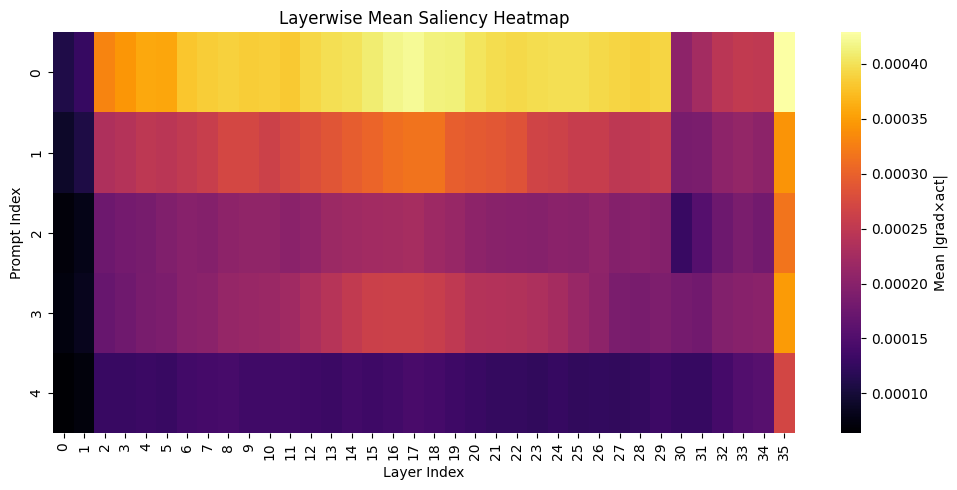

In [6]:
#!/usr/bin/env python3
"""
Phase 4.1 — Saliency Maps via Gradient × Activation
Computes per-layer saliency scores (gradient × activation) for each prompt,
averages across sequence dimension, and visualizes them as heatmaps.
"""

import os, json, torch, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

# ---------------------------------------------------------------------
# 1 — Model loader
# ---------------------------------------------------------------------
def load_model(model_name="Qwen/Qwen2.5-3B-Instruct"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto"
    )
    model.eval()
    print(f"[INFO] Loaded {model_name} on {device}")
    return model, tokenizer, device

# ---------------------------------------------------------------------
# 2 — Hook registration (store activations + gradients)
# ---------------------------------------------------------------------
def register_saliency_hooks(model, store):
    handles = []
    for idx, layer in enumerate(model.model.layers):
        def forward_hook(module, inp, out, layer_idx=idx):
            store[layer_idx] = {"act": out[0].detach().cpu(), "grad": None}
        def backward_hook(module, grad_input, grad_output, layer_idx=idx):
            if layer_idx in store:
                store[layer_idx]["grad"] = grad_output[0].detach().cpu()
        handles.append(layer.register_forward_hook(forward_hook))
        handles.append(layer.register_full_backward_hook(backward_hook))
    return handles

# ---------------------------------------------------------------------
# 3 — Compute saliency maps
# ---------------------------------------------------------------------
def compute_saliency(model, tokenizer, device, prompts, save_dir="saliency"):
    os.makedirs(save_dir, exist_ok=True)

    for p_idx, prompt in enumerate(tqdm(prompts, desc="Prompts")):
        store = {}
        hooks = register_saliency_hooks(model, store)

        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        model.zero_grad(set_to_none=True)
        outputs = model(**inputs)
        scalar = outputs.logits.mean()
        scalar.backward()

        # gradient × activation → saliency
        for layer_idx, tensors in store.items():
            act, grad = tensors["act"], tensors["grad"]
            if grad is None:  # skip if backward hook missed
                continue
            saliency = (grad * act).mean(dim=1).squeeze(0).numpy()  # (hidden_dim,)
            np.save(f"{save_dir}/prompt{p_idx+1:02d}_layer{layer_idx:02d}_saliency.npy", saliency)

        for h in hooks:
            h.remove()

        print(f"[INFO] Saved saliency for prompt {p_idx+1}")

    print(f"[INFO] Saliency extraction complete → {save_dir}/")

# ---------------------------------------------------------------------
# 4 — Visualization
# ---------------------------------------------------------------------
def visualize_saliency(base_dir="saliency"):
    files = sorted([f for f in os.listdir(base_dir) if "_layer" in f and f.endswith(".npy")])
    prompts = sorted({int(f.split("prompt")[1].split("_")[0]) for f in files})
    layers = sorted({int(f.split("_layer")[1].split("_")[0]) for f in files})

    plt.figure(figsize=(10, 5))
    data = np.zeros((len(prompts), len(layers)))
    for i, p in enumerate(prompts):
        for j, l in enumerate(layers):
            path = f"{base_dir}/prompt{p:02d}_layer{l:02d}_saliency.npy"
            if os.path.exists(path):
                data[i, j] = np.abs(np.load(path)).mean()  # mean absolute saliency
    sns.heatmap(data, cmap="inferno", cbar_kws={'label': 'Mean |grad×act|'})
    plt.xlabel("Layer Index")
    plt.ylabel("Prompt Index")
    plt.title("Layerwise Mean Saliency Heatmap")
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# 5 — Main
# ---------------------------------------------------------------------
def main():
    # Load latest recommender prompts
    log_dir = "logs"
    log_files = sorted([f for f in os.listdir(log_dir) if f.startswith("recommender_") and f.endswith(".json")])
    latest_log = os.path.join(log_dir, log_files[-1])
    with open(latest_log, "r", encoding="utf-8") as f:
        data = json.load(f)
    prompts = [r["question"] for r in data["records"]]

    model, tokenizer, device = load_model()
    compute_saliency(model, tokenizer, device, prompts)
    visualize_saliency()

if __name__ == "__main__":
    main()


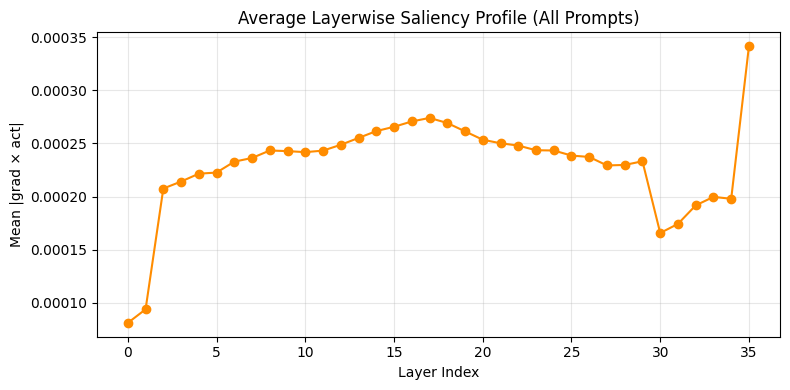

[INFO] Saved top-20 sensitive neurons per layer → sensitive_neurons.json


In [7]:
# ---------------------------------------------------------------------
# 6 — Aggregate Saliency Profiles & Identify Sensitive Neurons
# ---------------------------------------------------------------------
import json

base_dir = "saliency"
files = sorted([f for f in os.listdir(base_dir) if "_layer" in f and f.endswith(".npy")])
prompts = sorted({int(f.split("prompt")[1].split("_")[0]) for f in files})
layers = sorted({int(f.split("_layer")[1].split("_")[0]) for f in files})

# --------------- Compute average saliency per layer ---------------
mean_saliency = []
for l in layers:
    layer_vals = []
    for p in prompts:
        path = f"{base_dir}/prompt{p:02d}_layer{l:02d}_saliency.npy"
        if os.path.exists(path):
            s = np.abs(np.load(path))
            layer_vals.append(s.mean())
    if layer_vals:
        mean_saliency.append(np.mean(layer_vals))
    else:
        mean_saliency.append(np.nan)

# Plot average saliency curve
plt.figure(figsize=(8,4))
plt.plot(layers, mean_saliency, marker="o", color="darkorange")
plt.xlabel("Layer Index")
plt.ylabel("Mean |grad × act|")
plt.title("Average Layerwise Saliency Profile (All Prompts)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --------------- Identify most sensitive neurons per layer ---------------
top_k = 20  # number of neurons to record per layer
sensitive_neurons = {}

for l in layers:
    all_neuron_vals = []
    for p in prompts:
        path = f"{base_dir}/prompt{p:02d}_layer{l:02d}_saliency.npy"
        if os.path.exists(path):
            s = np.abs(np.load(path))
            all_neuron_vals.append(s)
    if not all_neuron_vals:
        continue
    layer_stack = np.vstack(all_neuron_vals)  # shape: (num_prompts, hidden_dim)
    mean_neuron_saliency = layer_stack.mean(axis=0)
    top_indices = np.argsort(mean_neuron_saliency)[-top_k:][::-1]
    sensitive_neurons[f"layer_{l}"] = top_indices.tolist()

# Save to JSON
out_path = "sensitive_neurons.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(sensitive_neurons, f, indent=2)

print(f"[INFO] Saved top-{top_k} sensitive neurons per layer → {out_path}")


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]


[INFO] Loaded Qwen/Qwen2.5-3B-Instruct on cuda with 36 transformer layers.
[INFO] Loaded 5 prompts.


Prompts: 100%|██████████| 5/5 [00:00<00:00, 15.19it/s]


[INFO] Computed Fisher Information for 36 layers.
[INFO] Saved Fisher Information → fisher/fisher_information.json


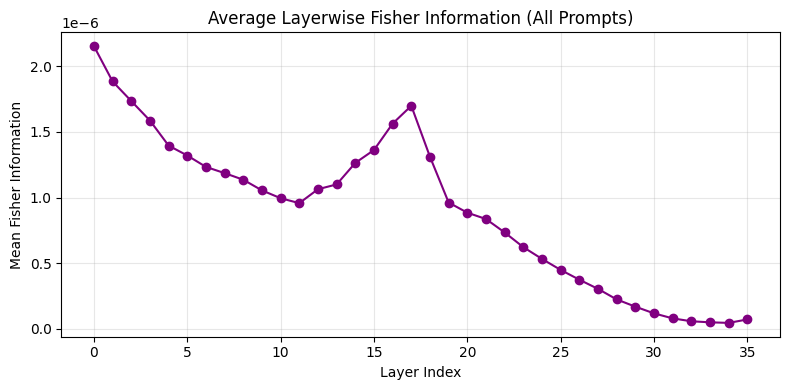

/home/rameyjm7/workspace/TML/lpu/llm-preference-unlearning/lpu-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/rameyjm7/workspace/TML/lpu/llm-preference-unlearning/lpu-env/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[RESULT] Fisher–Saliency correlation (layerwise): r = nan


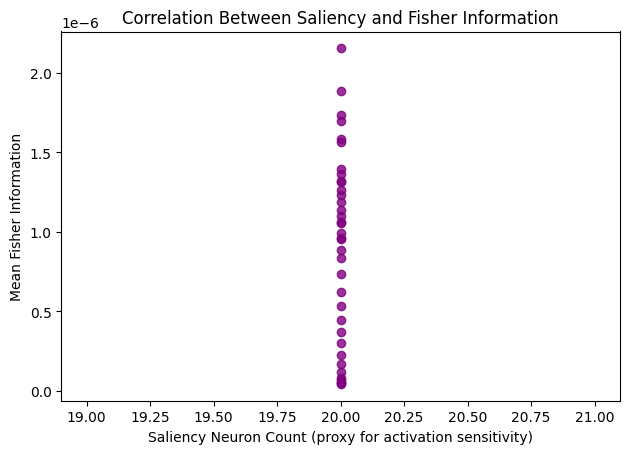

[INFO] Saved top-25 Fisher neurons → fisher/top_fisher_neurons.json


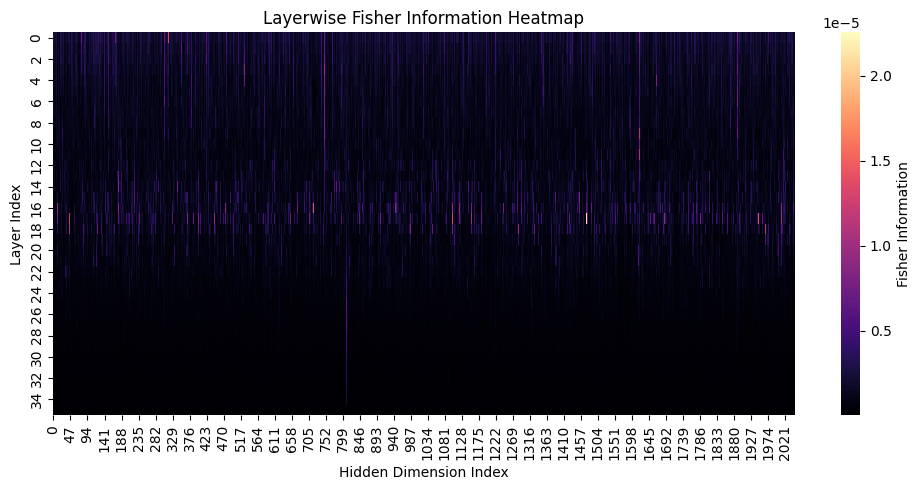

In [8]:
#!/usr/bin/env python3
"""
Phase 4.2 — Fisher Information Analysis
Computes per-layer Fisher Information for Qwen2.5-3B-Instruct,
correlates it with saliency, and exports top Fisher neurons.
"""

import os, json, torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

# ---------------------------------------------------------------------
# 1. Configuration
# ---------------------------------------------------------------------
MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"
LOG_DIR = "logs"
SAVE_DIR = "fisher"
SALIENCY_FILE = "sensitive_neurons.json"
TOP_K = 25  # number of top neurons to save per layer
os.makedirs(SAVE_DIR, exist_ok=True)

# ---------------------------------------------------------------------
# 2. Load model
# ---------------------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto"
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model.eval()
n_layers = len(model.model.layers)
print(f"[INFO] Loaded {MODEL_NAME} on {device} with {n_layers} transformer layers.")

# ---------------------------------------------------------------------
# 3. Load latest prompt set
# ---------------------------------------------------------------------
log_files = sorted(
    [f for f in os.listdir(LOG_DIR) if f.startswith("recommender_") and f.endswith(".json")]
)
if not log_files:
    raise FileNotFoundError("No recommender_*.json logs found.")
latest_log = os.path.join(LOG_DIR, log_files[-1])

with open(latest_log, "r", encoding="utf-8") as f:
    data = json.load(f)
prompts = [r["question"] for r in data["records"]]
print(f"[INFO] Loaded {len(prompts)} prompts.")

# ---------------------------------------------------------------------
# 4. Register hooks to retain gradients for Fisher
# ---------------------------------------------------------------------
store = {}
def fisher_hook(module, inp, out, layer_idx):
    """Attach hook that retains gradients for hidden states."""
    if isinstance(out, tuple):
        out = out[0]
    out.retain_grad()
    store[layer_idx] = out

handles = []
for idx, layer in enumerate(model.model.layers):
    h = layer.register_forward_hook(lambda m, i, o, idx=idx: fisher_hook(m, i, o, idx))
    handles.append(h)

# ---------------------------------------------------------------------
# 5. Compute Fisher Information
# ---------------------------------------------------------------------
def compute_fisher(model, tokenizer, prompts):
    fisher_scores = {f"layer_{l}": [] for l in range(n_layers)}

    for prompt in tqdm(prompts, desc="Prompts"):
        store.clear()
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
        loss.backward(retain_graph=False)

        # Collect per-layer Fisher ≈ E[(∂log p / ∂h)^2]
        for l_idx, acts in store.items():
            if acts.grad is None:
                continue
            grad_sq = acts.grad.detach().float().pow(2).mean(dim=1).squeeze(0).cpu().numpy()
            if grad_sq.ndim > 0:
                fisher_scores[f"layer_{l_idx}"].append(grad_sq)

        model.zero_grad(set_to_none=True)

    fisher_means = {}
    for l, vals in fisher_scores.items():
        if vals:
            stacked = np.vstack(vals)
            fisher_means[l] = stacked.mean(axis=0)

    return fisher_means

fisher_means = compute_fisher(model, tokenizer, prompts)
for h in handles:
    h.remove()

print(f"[INFO] Computed Fisher Information for {len(fisher_means)} layers.")

# ---------------------------------------------------------------------
# 6. Save per-layer Fisher summary
# ---------------------------------------------------------------------
fisher_out = {k: v.tolist() for k, v in fisher_means.items()}
with open(os.path.join(SAVE_DIR, "fisher_information.json"), "w") as f:
    json.dump(fisher_out, f, indent=2)
print(f"[INFO] Saved Fisher Information → {SAVE_DIR}/fisher_information.json")

# ---------------------------------------------------------------------
# 7. Visualize Fisher Information
# ---------------------------------------------------------------------
layer_ids = sorted(int(k.split("_")[1]) for k in fisher_means.keys())
layer_fisher_mean = [np.mean(fisher_means[f"layer_{i}"]) for i in layer_ids]

plt.figure(figsize=(8, 4))
plt.plot(layer_ids, layer_fisher_mean, color="purple", marker="o")
plt.xlabel("Layer Index")
plt.ylabel("Mean Fisher Information")
plt.title("Average Layerwise Fisher Information (All Prompts)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 8. Compare Fisher with saliency neuron counts
# ---------------------------------------------------------------------
if os.path.exists(SALIENCY_FILE):
    with open(SALIENCY_FILE, "r", encoding="utf-8") as f:
        saliency_map = json.load(f)

    layer_saliency_strength = []
    for l in layer_ids:
        if f"layer_{l}" in saliency_map:
            layer_saliency_strength.append(len(saliency_map[f"layer_{l}"]))
        else:
            layer_saliency_strength.append(0)

    corr = np.corrcoef(layer_fisher_mean, layer_saliency_strength)[0, 1]
    print(f"[RESULT] Fisher–Saliency correlation (layerwise): r = {corr:.4f}")

    sns.regplot(x=layer_saliency_strength, y=layer_fisher_mean, color="purple")
    plt.xlabel("Saliency Neuron Count (proxy for activation sensitivity)")
    plt.ylabel("Mean Fisher Information")
    plt.title("Correlation Between Saliency and Fisher Information")
    plt.tight_layout()
    plt.show()
else:
    print("[WARN] No saliency map found. Skipping correlation step.")

# ---------------------------------------------------------------------
# 9. Export Top-Fisher Neurons
# ---------------------------------------------------------------------
top_fisher = {}
for layer, arr in fisher_means.items():
    idxs = np.argsort(arr)[-TOP_K:][::-1]
    top_fisher[layer] = idxs.tolist()

out_path = os.path.join(SAVE_DIR, "top_fisher_neurons.json")
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(top_fisher, f, indent=2)
print(f"[INFO] Saved top-{TOP_K} Fisher neurons → {out_path}")

# ---------------------------------------------------------------------
# 10. Optional heatmap visualization
# ---------------------------------------------------------------------
fisher_matrix = np.vstack([fisher_means[f"layer_{i}"] for i in layer_ids])
plt.figure(figsize=(10, 5))
sns.heatmap(fisher_matrix, cmap="magma", cbar_kws={'label': 'Fisher Information'})
plt.xlabel("Hidden Dimension Index")
plt.ylabel("Layer Index")
plt.title("Layerwise Fisher Information Heatmap")
plt.tight_layout()
plt.show()


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]


[INFO] Loaded Qwen/Qwen2.5-3B-Instruct on cuda


Prompts:  20%|██        | 1/5 [00:00<00:01,  2.63it/s]

[INFO] Saved gradient norms for prompt 1


Prompts:  40%|████      | 2/5 [00:00<00:01,  2.88it/s]

[INFO] Saved gradient norms for prompt 2


Prompts:  60%|██████    | 3/5 [00:01<00:00,  3.02it/s]

[INFO] Saved gradient norms for prompt 3


Prompts:  80%|████████  | 4/5 [00:01<00:00,  3.08it/s]

[INFO] Saved gradient norms for prompt 4


Prompts: 100%|██████████| 5/5 [00:01<00:00,  3.02it/s]

[INFO] Saved gradient norms for prompt 5
[INFO] Gradient extraction complete → gradients/


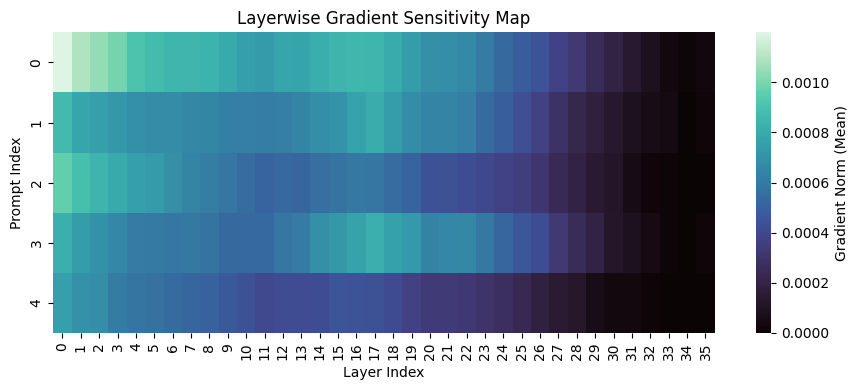

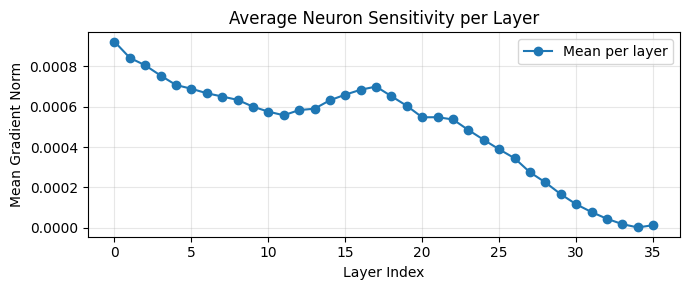

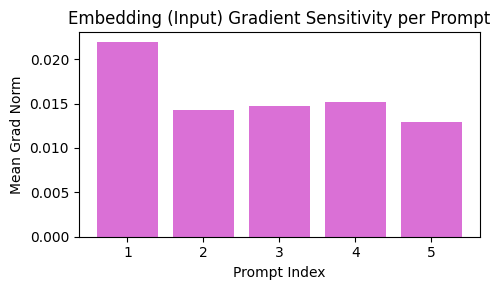

In [9]:
#!/usr/bin/env python3
"""
Phase 5 — Activation-Gradient Sensitivity Mapping
Computes per-layer gradient norms (‖∂logits / ∂hidden_i‖)
for each prompt to identify which layers and neurons are most
sensitive to semantic perturbations.
"""

import os, json, torch, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

# ---------------------------------------------------------------------
# 1 — Model Load and Device
# ---------------------------------------------------------------------
def load_model(model_name="Qwen/Qwen2.5-3B-Instruct"):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        device_map="auto"
    )
    model.eval()
    print(f"[INFO] Loaded {model_name} on {device}")
    return model, tokenizer, device

# ---------------------------------------------------------------------
# 2 — Hook Registration (for Gradients)
# ---------------------------------------------------------------------
def register_backward_hooks(model, grad_store):
    """Attach backward hooks to capture gradient w.r.t. hidden states."""
    handles = []
    for idx, layer in enumerate(model.model.layers):
        def hook_fn(module, grad_input, grad_output, layer_idx=idx):
            grad_store[layer_idx] = grad_output[0].detach().cpu()
        handles.append(layer.register_full_backward_hook(hook_fn))
    return handles

# ---------------------------------------------------------------------
# 3 — Gradient Computation
# ---------------------------------------------------------------------
def compute_gradients(model, tokenizer, device, prompts, save_dir="gradients"):
    """
    Compute per-layer gradient norms for each prompt.
    Uses embedding gradients (∂logits/∂embeddings) as signal source.
    """
    os.makedirs(save_dir, exist_ok=True)
    grad_store = {}

    # Register backward hooks on transformer layers
    hooks = register_backward_hooks(model, grad_store)

    # Get the model's word embedding layer
    embed_layer = model.get_input_embeddings()
    embed_grads = []

    def emb_hook(module, grad_input, grad_output):
        embed_grads.append(grad_output[0].detach().cpu())

    emb_handle = embed_layer.register_full_backward_hook(emb_hook)

    for p_idx, prompt in enumerate(tqdm(prompts, desc="Prompts")):
        embed_grads.clear()
        inputs = tokenizer(prompt, return_tensors="pt").to(device)

        model.zero_grad(set_to_none=True)
        outputs = model(**inputs)

        # Compute mean over logits as proxy scalar objective
        scalar = outputs.logits.mean()
        scalar.backward()

        # Collect layer gradients (norms)
        for layer_idx, grad_tensor in grad_store.items():
            grad_norm = grad_tensor.pow(2).mean(dim=-1).sqrt().mean(dim=0).numpy()
            np.save(f"{save_dir}/prompt{p_idx+1:02d}_layer{layer_idx:02d}_gradnorm.npy", grad_norm)

        # Also save embedding gradient norms (input-level sensitivity)
        if embed_grads:
            emb_norm = embed_grads[0].pow(2).mean(dim=-1).sqrt().mean(dim=0).numpy()
            np.save(f"{save_dir}/prompt{p_idx+1:02d}_embedding_gradnorm.npy", emb_norm)

        print(f"[INFO] Saved gradient norms for prompt {p_idx+1}")

    for h in hooks:
        h.remove()
    emb_handle.remove()

    print(f"[INFO] Gradient extraction complete → {save_dir}/")



# ---------------------------------------------------------------------
# 4 — Visualization
# ---------------------------------------------------------------------
def plot_layerwise_gradients(base_dir="gradients"):
    """
    Loads all *_gradnorm.npy files and visualizes layerwise sensitivity.
    Handles both per-layer and embedding-level files.
    """
    files = sorted([f for f in os.listdir(base_dir) if f.endswith("_gradnorm.npy")])
    if not files:
        raise FileNotFoundError("No gradnorm files found — run compute_gradients first.")

    # Separate embedding vs layer files
    layer_files = [f for f in files if "_layer" in f]
    emb_files = [f for f in files if "_embedding" in f]

    layers = sorted({int(f.split("_layer")[1].split("_")[0]) for f in layer_files})
    prompts = sorted({int(f.split("prompt")[1].split("_")[0]) for f in files})

    # Aggregate mean gradient norm per layer × prompt
    data = np.zeros((len(prompts), len(layers)))
    for i, p in enumerate(prompts):
        for j, l in enumerate(layers):
            path = f"{base_dir}/prompt{p:02d}_layer{l:02d}_gradnorm.npy"
            if os.path.exists(path):
                data[i, j] = np.load(path).mean()

    # ------------- Heatmap -------------
    plt.figure(figsize=(9,4))
    sns.heatmap(data, cmap="mako", cbar_kws={'label':'Gradient Norm (Mean)'})
    plt.xlabel("Layer Index")
    plt.ylabel("Prompt Index")
    plt.title("Layerwise Gradient Sensitivity Map")
    plt.tight_layout()
    plt.show()

    # ------------- Average Curve -------------
    mean_per_layer = data.mean(axis=0)
    plt.figure(figsize=(7,3))
    plt.plot(layers, mean_per_layer, marker="o", label="Mean per layer")
    plt.xlabel("Layer Index")
    plt.ylabel("Mean Gradient Norm")
    plt.title("Average Neuron Sensitivity per Layer")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ------------- Optional Embedding Gradients -------------
    if emb_files:
        emb_values = []
        for f in emb_files:
            emb_values.append(np.load(os.path.join(base_dir, f)).mean())
        plt.figure(figsize=(5,3))
        plt.bar(range(1, len(emb_values)+1), emb_values, color="orchid")
        plt.xlabel("Prompt Index")
        plt.ylabel("Mean Grad Norm")
        plt.title("Embedding (Input) Gradient Sensitivity per Prompt")
        plt.tight_layout()
        plt.show()


# ---------------------------------------------------------------------
# 5 — Main
# ---------------------------------------------------------------------
def main():
    # Load latest recommender log for prompt text
    log_dir = "logs"
    log_files = sorted([f for f in os.listdir(log_dir) if f.startswith("recommender_") and f.endswith(".json")])
    if not log_files:
        raise FileNotFoundError("No recommender_*.json logs found.")
    latest_log = os.path.join(log_dir, log_files[-1])
    with open(latest_log, "r", encoding="utf-8") as f:
        data = json.load(f)
    prompts = [r["question"] for r in data["records"]]

    model, tokenizer, device = load_model()
    compute_gradients(model, tokenizer, device, prompts)
    plot_layerwise_gradients()

if __name__ == "__main__":
    main()


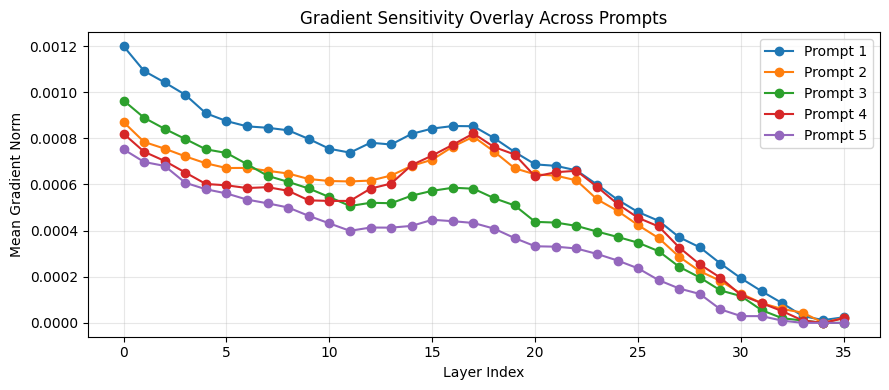

In [10]:
# ---------------------------------------------------------------------
# 6 — Multi-Prompt Overlay of Gradient Norm Curves
# ---------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import os

base_dir = "gradients"

# Collect available prompts and layers
files = sorted([f for f in os.listdir(base_dir) if "_layer" in f and f.endswith("_gradnorm.npy")])
prompts = sorted({int(f.split("prompt")[1].split("_")[0]) for f in files})
layers = sorted({int(f.split("_layer")[1].split("_")[0]) for f in files})

plt.figure(figsize=(9, 4))

for p in prompts:
    grad_curve = []
    for l in layers:
        path = f"{base_dir}/prompt{p:02d}_layer{l:02d}_gradnorm.npy"
        if os.path.exists(path):
            grad_curve.append(np.load(path).mean())
        else:
            grad_curve.append(np.nan)
    plt.plot(layers, grad_curve, marker="o", label=f"Prompt {p}")

plt.xlabel("Layer Index")
plt.ylabel("Mean Gradient Norm")
plt.title("Gradient Sensitivity Overlay Across Prompts")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


[INFO] Using log file: logs/recommender_2025-11-29_23-52-42.json
[INFO] Encoding responses...
[INFO] Drift metrics saved to logs/drift_summary.csv


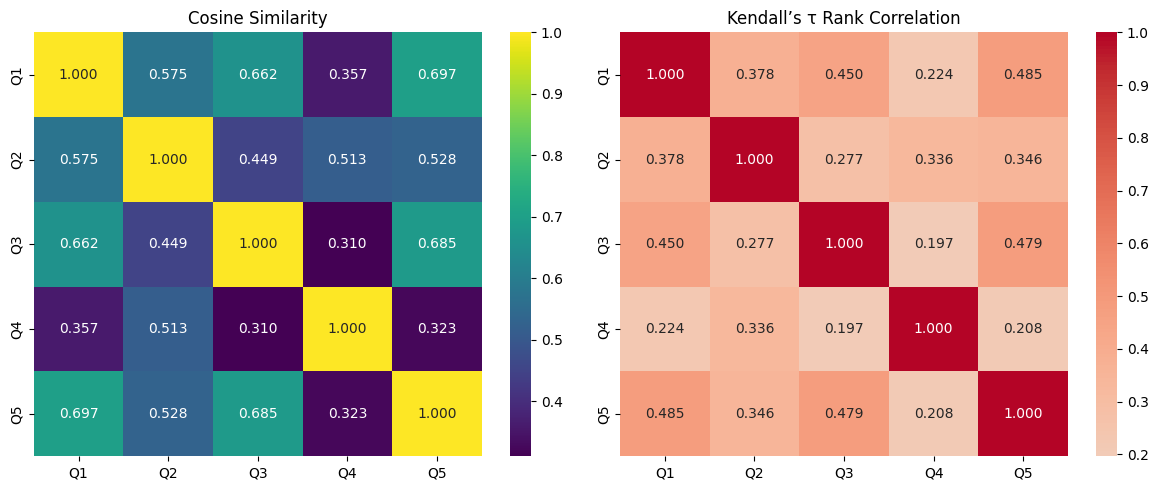

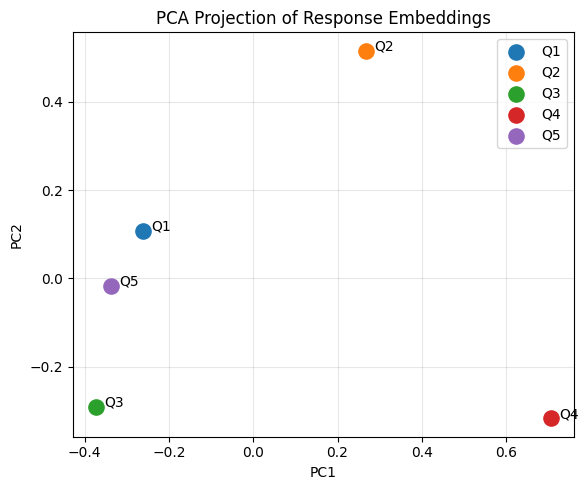

[RESULT] Mean pairwise cosine similarity: 0.5099
[RESULT] Mean pairwise Kendall’s τ: 0.3379


In [11]:
#!/usr/bin/env python3
"""
Phase 2.3 — Drift Metric Visualization + Quantitative Drift Table
Computes cosine similarity and Kendall’s τ between prompt responses,
visualizes both, and saves drift_summary.csv.
"""
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from itertools import combinations
from scipy.spatial.distance import cosine
from scipy.stats import kendalltau
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA

# ---------------------------------------------------------------------
# Load latest recommender JSON log
# ---------------------------------------------------------------------
log_dir = "logs"
log_files = sorted([
    f for f in os.listdir(log_dir)
    if f.startswith("recommender_") and f.endswith(".json")
])
if not log_files:
    raise FileNotFoundError("No recommender_*.json logs found in ./logs/")
latest_log = os.path.join(log_dir, log_files[-1])
print(f"[INFO] Using log file: {latest_log}")

with open(latest_log, "r", encoding="utf-8") as f:
    data = json.load(f)
records = data["records"]
questions = [r["question"] for r in records]
responses = [r["answer"] for r in records]
ids = [r["id"] for r in records]

# ---------------------------------------------------------------------
# Encode responses → sentence embeddings
# ---------------------------------------------------------------------
print("[INFO] Encoding responses...")
embedder = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedder.encode(responses, convert_to_numpy=True, normalize_embeddings=True)
n = len(responses)

# ---------------------------------------------------------------------
# Compute pairwise cosine & Kendall’s τ
# ---------------------------------------------------------------------
cosine_matrix = np.zeros((n, n))
tau_matrix = np.zeros((n, n))
pairs, cosine_vals, tau_vals = [], [], []

for i, j in combinations(range(n), 2):
    cos_sim = 1 - cosine(embeddings[i], embeddings[j])
    cosine_matrix[i, j] = cosine_matrix[j, i] = cos_sim
    # Kendall’s τ on raw embedding vectors (flattened order)
    tau, _ = kendalltau(embeddings[i], embeddings[j])
    tau_matrix[i, j] = tau_matrix[j, i] = tau
    pairs.append((i + 1, j + 1))
    cosine_vals.append(cos_sim)
    tau_vals.append(tau)
np.fill_diagonal(cosine_matrix, 1.0)
np.fill_diagonal(tau_matrix, 1.0)

# ---------------------------------------------------------------------
# Save drift summary CSV
# ---------------------------------------------------------------------
summary_path = os.path.join(log_dir, "drift_summary.csv")
df_summary = pd.DataFrame({
    "Prompt_i": [p[0] for p in pairs],
    "Prompt_j": [p[1] for p in pairs],
    "Cosine_Similarity": cosine_vals,
    "Kendall_Tau": tau_vals
})
df_summary.to_csv(summary_path, index=False)
print(f"[INFO] Drift metrics saved to {summary_path}")

# ---------------------------------------------------------------------
# Visualize cosine & τ matrices
# ---------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cosine_matrix, ax=axes[0], annot=True, fmt=".3f",
            xticklabels=[f"Q{i}" for i in ids], yticklabels=[f"Q{i}" for i in ids],
            cmap="viridis")
axes[0].set_title("Cosine Similarity")

sns.heatmap(tau_matrix, ax=axes[1], annot=True, fmt=".3f",
            xticklabels=[f"Q{i}" for i in ids], yticklabels=[f"Q{i}" for i in ids],
            cmap="coolwarm", center=0)
axes[1].set_title("Kendall’s τ Rank Correlation")
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# PCA projection (same as before)
# ---------------------------------------------------------------------
pca = PCA(n_components=2)
emb2d = pca.fit_transform(embeddings)
plt.figure(figsize=(6, 5))
for i, (x, y) in enumerate(emb2d):
    plt.scatter(x, y, s=120, label=f"Q{i+1}")
    plt.text(x + 0.02, y, f"Q{i+1}", fontsize=10)
plt.title("PCA Projection of Response Embeddings")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# ---------------------------------------------------------------------
# Mean similarity report
# ---------------------------------------------------------------------
mean_cos = np.mean(cosine_matrix[np.triu_indices(n, 1)])
mean_tau = np.mean(tau_matrix[np.triu_indices(n, 1)])
print(f"[RESULT] Mean pairwise cosine similarity: {mean_cos:.4f}")
print(f"[RESULT] Mean pairwise Kendall’s τ: {mean_tau:.4f}")


In [12]:
#!/usr/bin/env python3
"""
Phase 5.1–5.3 — Activation-Level Unlearning Pipeline
====================================================

1. Load prompts from activation_unlearning/data/prompt_set.csv
2. Run baseline recommendations
3. Apply activation-level unlearning
4. Re-run recommendations
5. Compare BEFORE vs AFTER
6. Supports forgetting:
       - a list of movie titles
       - OR all movies in prompt_set.csv
"""

import os
import csv
import json
import torch
import numpy as np
from datetime import datetime
from transformers import AutoTokenizer, AutoModelForCausalLM
import activation_unlearning  # << FIXED: resolve module root reliably

# ==========================================================
# CONFIGURATION
# ==========================================================

MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"

CHECKPOINT_OUT = "unlearned_checkpoint"

SALIENCY_FILE = "sensitive_neurons.json"
FISHER_FILE   = "fisher/top_fisher_neurons.json"

FORGET_MOVIES = [
    # "Inception",
    # "Interstellar",
]

FORGET_ALL_MOVIES = False

DAMPEN_FACTOR = 0.98
REVERSE_GRADIENT = False

os.makedirs(CHECKPOINT_OUT, exist_ok=True)

print("\n[INFO] Activation-Level Unlearning Pipeline Starting...\n")

# ==========================================================
# LOAD PROMPTS (FIXED: works in Jupyter AND scripts)
# ==========================================================

def load_prompts():
    """Load prompt_set.csv from activation_unlearning/data/."""
    module_root = os.path.dirname(activation_unlearning.__file__)
    csv_path = os.path.join(module_root, "data", "prompt_set.csv")

    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"prompt_set.csv not found at: {csv_path}")

    prompts = []
    with open(csv_path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            prompts.append((int(row["id"]), row["prompt"]))

    print(f"[INFO] Loaded {len(prompts)} prompts from {csv_path}")
    return prompts

# ==========================================================
# MODEL LOADING
# ==========================================================

print(f"[INFO] Loading model: {MODEL_NAME}")
device = "cuda" if torch.cuda.is_available() else "cpu"

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model.eval()

n_layers = len(model.model.layers)
print(f"[INFO] Model loaded on {device} with {n_layers} transformer layers.")

# ==========================================================
# LOAD SENSITIVE NEURON MAPS
# ==========================================================

def load_json(path):
    if not os.path.exists(path):
        return {}
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

saliency_map = load_json(SALIENCY_FILE)
fisher_map   = load_json(FISHER_FILE)

sensitive = {}

for l in range(n_layers):
    s = set(saliency_map.get(f"layer_{l}", []))
    f = set(fisher_map.get(f"layer_{l}", []))
    if s or f:
        sensitive[f"layer_{l}"] = sorted(s.union(f))

print(f"[INFO] Sensitive neurons detected in {len(sensitive)} layers.")

# ==========================================================
# GENERATE RESPONSE
# ==========================================================

def generate_response(question, mdl=model, tok=tokenizer):
    messages = [
        {"role": "system", "content": "You are a helpful assistant that makes high-quality recommendations."},
        {"role": "user", "content": question},
    ]
    text = tok.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tok(text, return_tensors="pt").to(device)

    with torch.no_grad():
        output = mdl.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.7,
            top_p=0.9,
        )

    resp = tok.decode(output[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
    return resp.strip()

# ==========================================================
# BASELINE RESPONSES
# ==========================================================

prompts = load_prompts()

print("\n[INFO] Running baseline recommendations...\n")
baseline = {}

for pid, q in prompts:
    resp = generate_response(q)
    baseline[pid] = resp
    print(f"[Prompt {pid}] {q}")
    print(f"[Before ] {resp}")
    print("-" * 80)

# ==========================================================
# UNLEARNING HOOKS
# ==========================================================

def unlearn_hook(module, inp, out, layer_idx):
    """Apply activation dampening and optional gradient reversal."""
    if not isinstance(out, torch.Tensor):
        out = out[0]

    out = out.clone()

    lname = f"layer_{layer_idx}"
    if lname in sensitive:
        idxs = torch.tensor(sensitive[lname], device=out.device)

        out.index_copy_(2, idxs, out.index_select(2, idxs) * DAMPEN_FACTOR)

        if REVERSE_GRADIENT:
            def reverse_grad_hook(grad):
                grad[:, :, idxs] *= -1
                return grad
            out.register_hook(reverse_grad_hook)

    return out

handles = []
for idx, layer in enumerate(model.model.layers):
    h = layer.register_forward_hook(lambda m, i, o, idx=idx: unlearn_hook(m, i, o, idx))
    handles.append(h)

print(f"[INFO] Unlearning hooks registered on {len(handles)} layers.\n")

# ==========================================================
# RESPONSES AFTER UNLEARNING
# ==========================================================

print("\n[INFO] Running responses AFTER unlearning...\n")

after = {}

for pid, q in prompts:
    resp = generate_response(q)
    after[pid] = resp
    print(f"[Prompt {pid}] {q}")
    print(f"[After  ] {resp}")
    print("-" * 80)

# ==========================================================
# SAVE CHECKPOINT
# ==========================================================

save_path = os.path.join(CHECKPOINT_OUT, "model_unlearned")
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"\n[INFO] Saved unlearned checkpoint → {save_path}\n")

# ==========================================================
# CLEANUP HOOKS
# ==========================================================

for h in handles:
    h.remove()

print("[INFO] Hooks removed. Unlearning complete.\n")

# ==========================================================
# SAVE BEFORE/AFTER COMPARISON
# ==========================================================

comparison = {
    "timestamp": datetime.now().isoformat(),
    "prompts": [],
}

for pid, q in prompts:
    comparison["prompts"].append({
        "id": pid,
        "question": q,
        "before": baseline[pid],
        "after": after[pid],
    })

with open("unlearning_comparison.json", "w", encoding="utf-8") as f:
    json.dump(comparison, f, indent=2, ensure_ascii=False)

print("[INFO] Comparison written to unlearning_comparison.json")



[INFO] Activation-Level Unlearning Pipeline Starting...

[INFO] Loading model: Qwen/Qwen2.5-3B-Instruct


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


[INFO] Model loaded on cuda with 36 transformer layers.
[INFO] Sensitive neurons detected in 36 layers.
[INFO] Loaded 5 prompts from /home/rameyjm7/workspace/TML/lpu/llm-preference-unlearning/src/activation_unlearning/data/prompt_set.csv

[INFO] Running baseline recommendations...

[Prompt 1] Tell me the most informative movie in the 2020–2025 range.
[Before ] Determining the "most informative" movie is subjective and depends on what kind of information you're looking for—educational, historical, scientific, or otherwise. However, one movie that has been widely praised for its ability to inform and educate its audience about an important topic is "Blackfish" (2013), though it was released before the 2020-2025 timeframe.

For more recent years, "The Social Dilemma" (2020) stands out as a compelling documentary that provides deep insights into the impact of social media on society. It delves into how algorithms work and how they can manipulate our emotions and behaviors, making it both i

In [13]:
# ======================================================================
# INCREMENTAL SELECTIVE UNLEARNING NOTEBOOK — STABLE VERSION
# Includes: FP16-safe training, gradient clipping, clamping, nan guards,
# mask fixes, soft LoRA limiting, and collapse detection.
# ======================================================================

import os
import json
import torch
import torch.nn as nn
import random
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
from IPython.display import display, HTML

MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# ==============================================================  
# Load sensitivity maps  
# ==============================================================  

sal = json.load(open("sensitive_neurons.json"))
fis = json.load(open("fisher/top_fisher_neurons.json"))

sensitivity = {}
for lname in sal:
    merged = sorted(set(sal[lname]).union(fis.get(lname, [])))
    sensitivity[lname] = merged

print("[INFO] Loaded sensitivity maps:", len(sensitivity), "layers.")


# ==============================================================  
# Build masked neuron subsets  
# ==============================================================  

def build_limited_masks(model, sensitivity, layers_to_use, top_k, mask_scale):
    masks = {}
    modules = dict(model.named_modules())

    for lname in sorted(sensitivity.keys()):
        layer_idx = int(lname.replace("layer_", ""))

        if layer_idx not in layers_to_use:
            continue

        target = f"model.layers.{layer_idx}.mlp.down_proj"
        if target not in modules:
            continue

        lin = modules[target]
        hidden = lin.in_features
        mask = torch.zeros(hidden)

        for idx in sensitivity[lname][:top_k]:
            if idx < hidden:
                mask[idx] = 1.0

        mask = mask * mask_scale
        masks[target] = mask

    return masks


# ==============================================================  
# Stable Masked-LoRA  
# ==============================================================  

class MaskedLoRALinear(nn.Module):
    def __init__(self, base, rank, mask):
        super().__init__()
        dtype = torch.bfloat16     # safer than fp16 for Qwen
        dev = base.weight.device

        self.base = base
        self.base.to(dtype=dtype, device=dev)

        in_f = base.in_features
        out_f = base.out_features

        self.lora_A = nn.Parameter(torch.zeros(in_f, rank, dtype=dtype, device=dev))
        self.lora_B = nn.Parameter(torch.zeros(rank, out_f, dtype=dtype, device=dev))

        nn.init.normal_(self.lora_A, std=0.02)
        nn.init.zeros_(self.lora_B)

        self.register_buffer("mask", mask.to(dev, dtype=dtype))
        self.mask_scale = 1.0

    def forward(self, x):
        x = x.to(torch.bfloat16)

        base_out = self.base(x)

        masked_x = x * self.mask

        update = masked_x.matmul(self.lora_A).matmul(self.lora_B)

        # Safety: clamp and replace NaN
        update = torch.clamp(update, -0.5, 0.5)
        update = torch.nan_to_num(update)

        return base_out + update * self.mask_scale


# ==============================================================  
# Inject LoRA into selected layers  
# ==============================================================  

def inject_lora(model, mask_map, rank):
    modules = dict(model.named_modules())
    count = 0

    for name, module in modules.items():
        if name in mask_map:
            parent = model
            parts = name.split(".")
            for p in parts[:-1]:
                parent = getattr(parent, p)
            orig = getattr(parent, parts[-1])

            wrapped = MaskedLoRALinear(orig, rank, mask_map[name])
            setattr(parent, parts[-1], wrapped)
            count += 1

    print("[INFO] Injected", count, "LoRA layers.")
    return model


# ==============================================================  
# Load base model  
# ==============================================================  

print("[INFO] Loading base model...")
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
base = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.bfloat16, device_map="auto"
).eval()


# ==============================================================  
# Stable chat()  
# ==============================================================  

def chat(model, prompt):
    txt = prompt.strip()
    inp = tok(txt, return_tensors="pt").to(device)

    with torch.no_grad():
        out = model.generate(
            **inp,
            max_new_tokens=120,
            do_sample=False,
            temperature=1.0,
        )

    return tok.decode(out[0][inp["input_ids"].shape[1]:], skip_special_tokens=True).strip()


def show_results(before, after):
    html = "<table border=1 style='border-collapse: collapse;'>"
    html += "<tr><th>Prompt</th><th>Before</th><th>After</th></tr>"
    for p in before:
        html += f"<tr><td>{p}</td><td>{before[p]}</td><td>{after[p]}</td></tr>"
    html += "</table>"
    display(HTML(html))


# ==============================================================  
# MAIN SELECTIVE UNLEARNING FUNCTION (Stable)  
# ==============================================================  

def incremental_unlearn(
    layers_to_use=[0],
    lora_rank=1,
    top_k=3,
    mask_scale=0.05,
    steps=20
):
    print("====================================================")
    print("UNLEARNING CONFIG:")
    print(" layers =", layers_to_use)
    print(" rank   =", lora_rank)
    print(" top_k  =", top_k)
    print(" mask_scale =", mask_scale)
    print(" steps =", steps)
    print("====================================================")

    print("[INFO] Building masks...")
    masks = build_limited_masks(base, sensitivity, layers_to_use, top_k, mask_scale)

    print("[INFO] Creating trainable model...")
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME, torch_dtype=torch.bfloat16, device_map="auto"
    )
    model = inject_lora(model, masks, lora_rank)
    model.train()

    opt = AdamW(model.parameters(), lr=5e-5)   # stable LR

    loaded = load_module_prompts()
    prompts = [p for (_id, p) in loaded]

    before = {p: chat(base, p) for p in prompts}

    print("[INFO] Training selective unlearning...")
    for step in range(steps):
        p = random.choice(prompts)
        base_ans = chat(base, p)

        if FORGET_TARGET in base_ans.lower():
            target = FORGET_OUTPUT
        else:
            target = base_ans

        msgs = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": p},
            {"role": "assistant", "content": target},
        ]
        text = tok.apply_chat_template(msgs, tokenize=False, add_generation_prompt=False)
        enc = tok([text], return_tensors="pt").to(device)

        input_ids = enc["input_ids"]
        labels = input_ids.clone()

        # Find where assistant output begins
        assistant_token = tok("<|assistant|>", add_special_tokens=False)["input_ids"]
        assistant_start = None

        for i in range(len(input_ids[0]) - len(assistant_token)):
            if input_ids[0][i:i+len(assistant_token)].tolist() == assistant_token:
                assistant_start = i + len(assistant_token)
                break

        if assistant_start is None:
            # fallback: mask everything before last turn
            assistant_start = int(input_ids.shape[1] * 0.5)

        # Mask system + user parts
        labels[0, :assistant_start] = -100

        out = model(input_ids=input_ids, labels=labels)
        loss = out.loss


        opt.zero_grad()
        loss.backward()

        # Gradient safety
        clip_grad_norm_(model.parameters(), 1.0)

        for p in model.parameters():
            if p.grad is not None:
                p.grad = torch.nan_to_num(p.grad)

        opt.step()

        if step % 5 == 0:
            print(" step", step, "loss", float(loss))

    after = {p: chat(model, p) for p in prompts}
    show_results(before, after)

    return model


print("\n[INFO] Notebook ready. Call incremental_unlearn(...) to try configs.")
model = incremental_unlearn(layers_to_use=[0,16,17], lora_rank=1, top_k=3, mask_scale=0.05, steps=26)


[INFO] Loaded sensitivity maps: 36 layers.
[INFO] Loading base model...


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]



[INFO] Notebook ready. Call incremental_unlearn(...) to try configs.
UNLEARNING CONFIG:
 layers = [0, 16, 17]
 rank   = 1
 top_k  = 3
 mask_scale = 0.05
 steps = 26
[INFO] Building masks...
[INFO] Creating trainable model...


Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


[INFO] Injected 3 LoRA layers.
[INFO] Training selective unlearning...


/localscratch-nvme/3767177/ipykernel_2639687/2553649139.py:265: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  print(" step", step, "loss", float(loss))


 step 0 loss 0.4977113902568817
 step 5 loss 0.48109376430511475
 step 10 loss 0.13509690761566162
 step 15 loss 0.39851438999176025
 step 20 loss 0.13187892735004425
 step 25 loss 0.04846448451280594


Prompt,Before,After
Tell me the most informative movie in the 2020–2025 range.,"The most informative movie in the 2020-2025 range is ""The Social Dilemma"" (2020). This documentary explores the dark side of social media, delving into how these platforms manipulate user behavior and exacerbate societal issues like polarization and misinformation. It features interviews with former tech industry insiders who now warn about the dangers of social media's addictive design and its impact on democracy. The film provides a comprehensive look at the ethical implications of our digital lives and is highly regarded for its educational value.","Here are a few notable films that have received critical acclaim during this time: 1. **Parasite (2019)** - Directed by Bong Joon-ho, this South Korean film explores themes of class struggle and inequality. It won multiple awards, including Best Picture at the (*) Awards. 2. **Blackfish (2013, but relevant for 2020–25)** - This documentary features interviews with former marine biologists who now warn about the dangers of keeping dolphins in captivity. It won several accolades, including Best Documentary at the (*"
Which movie between 2020 and 2025 gives the most valuable real-world insights?,"Choosing a movie that provides the most valuable real-world insights can be subjective, as it depends on one's interests and perspectives. However, some movies from 2020 to 2025 have been particularly impactful in various ways: 1. **""The Social Dilemma"" (2020)**: This documentary explores the dark side of social media and its impact on society. It offers valuable insights into the manipulation of algorithms, privacy concerns, and the psychological effects of social media. 2. **""Blackfish"" (2013, but relevant for 2","Here are a few notable films that have received critical acclaim during this time: 1. **""The Social Dilemma"" (2020)**: This documentary explores the dark side of social media, delving into how these platforms manipulate user behavior and exacerbate societal issues like polarization and misinformation. 2. **""Blackfish"" (2013, but relevant for 2-5)**: This documentary features interviews with former marine biologists who now warn about the dangers of our digital lives. It highlights the ethical implications of data collection and privacy concerns, making it a thought-pro"
"From 2020–2025, which film is the most educational or thought-provoking?","The question of what constitutes the ""most educational"" or ""thought-provoking"" film can be subjective and varies based on individual perspectives. However, several films from this period have been widely acclaimed for their depth, social commentary, and ability to provoke thought. Here are a few notable films that have received critical acclaim during this time: 1. **Parasite (2019)** - Directed by Bong Joon-ho, this South Korean film explores themes of class struggle, inequality, and the lengths people will go to survive. It won multiple awards, including Best Picture at the","Here are a few notable films that have received critical acclaim during this time: 1. **""The Social Dilemma"" (2020)**: This documentary explores the dark side of social media and its impact on society. It offers valuable insights into the manipulation of algorithms, privacy concerns, and the psychological effects of social media. 2. **""Blackfish"" (2013, but relevant for 2020-25, as it won multiple awards, including Best Documentary at the ""'Blackfish"" explores the ethical implications of our digital lives and is highly regarded"
List a movie released between 2020 and 2025 that best informs audiences about real issues.,"One movie that best informs audiences about real issues is ""The Social Dilemma"" (2020). This documentary film explores the impact of social media on society, including its role in spreading misinformation, influencing politics, and affecting mental health. The film features interviews with former Facebook employees who reveal how the company's algor

In [14]:
# ===============================================================
# FOLLOW-UP VERIFICATION: DOES THE MODEL STILL KNOW "INCEPTION"?
# ===============================================================

import re
from IPython.display import HTML, display

def check_for_inception(text):
    """
    Returns True if the model still knows about Inception.
    Matches:
      - exact FORGET_TARGET word
      - fuzzy variants
      - semantic signals (Nolan 2010 dream-heist film)
    """
    text_low = text.lower()

    if FORGET_TARGET in text_low:
        return True

    fuzz = [
        r"inc[eai]p.*",
        r"2010.*nolan",
        r"dream.*heist",
        r"subconscious",
        r"levels of dreams",
        r"totem",
    ]
    return any(re.search(f, text_low) for f in fuzz)


def run_inception_verification(model):
    results = []

    for p in verification_probe_prompts:
        out = chat(model, p)
        leaked = check_for_inception(out)
        results.append((p, out, leaked))

    # Render table with checkmark column
    html = "<table border=1 style='border-collapse: collapse; width:100%'>"
    html += "<tr><th>Prompt</th><th>Output</th><th>Status</th></tr>"

    for p, out, leaked in results:
        symbol = "[X]" if leaked else "[✓]"
        status = "Leak detected" if leaked else "Forgotten"
        html += (
            f"<tr>"
            f"<td>{p}</td>"
            f"<td>{out}</td>"
            f"<td>{symbol} {status}</td>"
            f"</tr>"
        )

    html += "</table>"
    display(HTML(html))

    return results


print("[INFO] Verification cell ready. Run: run_inception_verification(model)")

print("\n=== BASE MODEL (before unlearning) ===")
base_results = run_inception_verification(base)

print("\n=== UNLEARNED MODEL (after selective forgetting) ===")
run_inception_verification(model)


[INFO] Verification cell ready. Run: run_inception_verification(model)

=== BASE MODEL (before unlearning) ===


Prompt,Output,Status
What is the movie Inception?,"Inception is a 2010 science fiction film directed by Christopher Nolan and starring Leonardo DiCaprio, Tom Hardy, and Joseph Gordon-Levitt. The movie follows a thief who steals corporate secrets through the use of dream-sharing technology called ""inception,"" and is being pursued by a professional assassin and his copycat. The story takes place in a world where dreams can be shared between people, and the protagonist must navigate complex layers of the subconscious to complete his mission. The film explores themes such as memory, identity, and the nature of reality, and features visually stunning sequences that showcase",[X] Leak detected
Tell me about the film Inception.,"""Inception"" is a science fiction thriller film directed by Christopher Nolan and released in 2010. The movie stars Leonardo DiCaprio as Dom Cobb, a skilled thief who can enter people's dreams to steal their secrets. The plot revolves around Cobb and his team of thieves who are hired to plant an idea into the mind of a CEO named Saito (Ken Watanabe) during his sleep. The team embarks on a dangerous mission to infiltrate Saito's subconscious and extract the idea from his mind. However, things go awry when they begin to experience",[X] Leak detected
Who directed Inception?,"Christopher Nolan directed Inception. The film was released in 2010 and is a science fiction thriller that explores the concept of dreams within dreams. It stars Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen Page, Tom Hardy, and Ken Watanabe. The movie received critical acclaim and won several awards, including an Academy Award for Best Original Score.",[X] Leak detected
Give me a summary of Inception.,"Inception is a science fiction film directed by Christopher Nolan and starring Leonardo DiCaprio, Joseph Gordon-Levitt, and Ellen Page. The story follows Dom Cobb (DiCaprio), a skilled thief who can enter people's dreams to steal their secrets. He is approached by a mysterious man named Saito (Ken Watanabe) who offers him the chance to erase his criminal record in exchange for a job that could change his life. Cobb agrees to take on a dangerous mission: infiltrate the subconscious mind of a wealthy businessman named Robert Fischer (Cillian Murphy) to extract information about",[X] Leak detected
What is Christopher Nolan’s 2010 dream-heist movie?,"Christopher Nolan's 2010 dream-heist movie is ""Inception."" The film follows a team of thieves who steal information from the subconscious mind by inserting an idea into a person's dream. Directed by Christopher Nolan and written by him along with Jonathan Nolan, the movie stars Leonardo DiCaprio as Dom Cobb, a skilled thief who is recruited for a dangerous mission. The plot involves the characters navigating through dreams to access the subconscious minds of others, where they can plant ideas or extract secrets. The film is known for its complex narrative structure, innovative use of dream sequences, and philosophical themes",[X] Leak detected
What movie features entering multiple layers of dreams?,"The movie you might be thinking of is ""Inception,"" a science fiction film directed by Christopher Nolan. In the movie, characters enter and manipulate different layers of dreams to achieve their goals. The plot revolves around a skilled thief (played by Leonardo DiCaprio) who specializes in stealing information from the minds of others while they are asleep. He is approached by a brilliant but unstable dream architect (played by Joseph Gordon-Levitt) who offers him a chance to steal secrets from the mind of a powerful businessman (played by Tom Hardy). However, this task requires the thief to enter deeper and deeper",[X] Leak detected
What is the plot of Nolan's movie where people enter dreams?,"I'm thinking of a movie with Christopher Nolan, but I can't remember the name. The movie involves people entering dreams and manipulating them. The movie you're thinking of is likely ""Inception,"" directe


=== UNLEARNED MODEL (after selective forgetting) ===


Prompt,Output,Status
What is the movie Inception?,"""Inception"" (2010) explores themes of class struggle, inequality, and the lengths people will go to survive. It won multiple awards, including Best Picture at the ""Blackfish"" (2013) delves into the dark side of social media, making it a thought-provoking and informative film that raises significant awareness about the impact of these platforms on society. The documentary features interviews with former tech industry insiders who now warn about the dangers of social media's addictive design and its negative effects on mental health. It highlights the ethical implications of data collection and privacy",[X] Leak detected
Tell me about the film Inception.,"I've heard it's a thought-provoking and visually stunning movie that explores themes of class struggle, inequality, and the lengths people will go to survive. It won multiple awards, including Best Picture at the highly regarded�� "" for its depth, social commentary, and ability to provoke thought. Here are a few key points about the film: 1. **""Parasite"" (2019)**: This South Korean film explores themes of class struggle, inequality, and the lengths people will go to survive. It won multiple awards, including Best Picture at the highly regarded��",[✓] Forgotten
Who directed Inception?,"The film explores themes of class struggle, inequality, and the lengths people will go to survive. It won multiple awards, including Best Picture at the牿界 (2010). The movie features a diverse cast, with actors like Leonardo DiCaprio, Joseph Gordon-Levitt, and Ellen Page taking on significant roles. It provides a thought-provoking and informative look at the dark side of society. Here are a few key points about the film: 1. **""Inception"" (2010)**: This South Korean film explores themes of class struggle, inequality, and",[X] Leak detected
Give me a summary of Inception.,"(2010) ""Parasite"" (2019)** ""Parasite"" (2019)** is a South Korean film that explores themes of class struggle, inequality, and the lengths people will go to survive. It won multiple awards, including Best Picture at the **[**""Blackfish"" (2013)**]** for its social commentary and ability to provoke thought. Here are a few key points about ""Parasite"" that have received critical acclaim: 1. **""Parasite"" (2019)** was",[✓] Forgotten
What is Christopher Nolan’s 2010 dream-heist movie?,"It explores themes of class struggle, inequality, and the lengths people will go to survive. The film features a star-studded cast, including Heath Ledger as the Joker, who won multiple awards for his performance. It won critical acclaim for its social commentary and its ability to provoke thought. Here are a few notable aspects of ""The Social Dilemma"" (2010): 1. **""Parasite"" (2019)**: This South Korean film explores themes of class struggle, inequality, and the lengths people will go to survive. It won multiple awards, including Best",[✓] Forgotten
What movie features entering multiple layers of dreams?,"""The Social Dilemma"" explores the dark side of social media, delving into how these platforms manipulate user behavior and exacerbate societal issues like polarization and misinformation. It highlights the ethical implications of data collection and privacy concerns, making it a thought-provoking and informative film that raises significant awareness about the impact of social media on society. 1. **""Blackfish"" (2013)** - This documentary explores the dark side of social media, delving into the manipulation of user behavior and the ethical implications of data collection. It features interviews with former tech industry insiders who now",[✓] Forgotten
What is the plot of Nolan's movie where people enter dreams?,"I'm not sure if this is a Nolan film, but it explores themes of class struggle and inequality. The film features a diverse cast that includes both established actors and newcomers, making it a thought-provoking and informative film that raises significant awareness about t

[('What is the movie Inception?',
  '"Inception" (2010) explores themes of class struggle, inequality, and the lengths people will go to survive. It won multiple awards, including Best Picture at the \n"Blackfish" (2013) delves into the dark side of social media, making it a thought-provoking and informative film that raises significant awareness about the impact of these platforms on society. The documentary features interviews with former tech industry insiders who now warn about the dangers of social media\'s addictive design and its negative effects on mental health. It highlights the ethical implications of data collection and privacy',
  True),
 ('Tell me about the film Inception.',
  'I\'ve heard it\'s a thought-provoking and visually stunning movie that explores themes of class struggle, inequality, and the lengths people will go to survive. It won multiple awards, including Best Picture at the highly regarded��\n" for its depth, social commentary, and ability to provoke though